# Examining Real Data

We start by sourcing and examining real world rotation preference data from CCLCM students for enhanced modeling. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

real = pd.read_csv("/work/real.csv")
real

,StudentID,IM/Surgery,Peds/Ob/Gyn,Neuro/Psych,Ambulatory Block
0,anon_ccf_1,1st Rotation,2nd Rotation,3rd Rotation,4th Rotation
1,anon_ccf_2,3rd Rotation,2nd Rotation,1st Rotation,4th Rotation
2,anon_ccf_3,1st Rotation,3rd Rotation,2nd Rotation,4th Rotation
3,anon_ccf_4,2nd Rotation,4th Rotation,1st Rotation,3rd Rotation
4,anon_ccf_5,2nd Rotation,1st Rotation,3rd Rotation,4th Rotation
5,anon_ccf_6,4th Rotation,3rd Rotation,1st Rotation,2nd Rotation
6,anon_ccf_7,3rd Rotation,1st Rotation,2nd Rotation,4th Rotation
7,anon_ccf_8,2nd Rotation,1st Rotation,3rd Rotation,4th Rotation
8,anon_ccf_9,3rd Rotation,2nd Rotation,1st Rotation,4th Rotation
9,anon_ccf_10,1st Rotation,2nd Rotation,3rd Rotation,4th Rotation


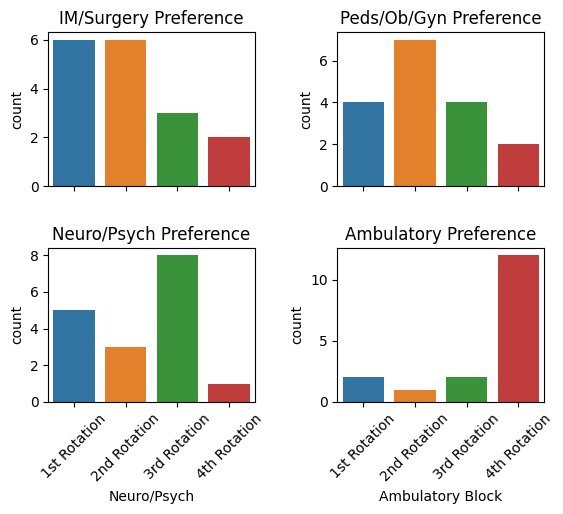

In [2]:
 rotation_order = ["1st Rotation", "2nd Rotation", "3rd Rotation", "4th Rotation"]

fig = plt.figure()
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
ax = fig.add_subplot(2, 2, 1)
sns.countplot(data = real, x = "IM/Surgery", order = rotation_order, ax = ax).set(title='IM/Surgery Preference', xlabel = None, xticklabels=[])
ax = fig.add_subplot(2, 2, 2)
sns.countplot(data = real, x = "Peds/Ob/Gyn", order = rotation_order, ax = ax).set(title='Peds/Ob/Gyn Preference', xlabel = None, xticklabels=[])
ax = fig.add_subplot(2, 2, 3)
sns.countplot(data = real, x = "Neuro/Psych", order = rotation_order, ax = ax).set(title='Neuro/Psych Preference')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax = fig.add_subplot(2, 2, 4)
sns.countplot(data = real, x = "Ambulatory Block", order = rotation_order, ax = ax).set(title='Ambulatory Preference')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

## Creating Mock Data
From the real-world data, it is clear that generally, the ambulatory block is the fourth preference. IM/Surgery generally has a high rate of first and second preference, and Psych/Neuro generally has a high rate of third preference. We can design our mock data to fit these expectations to better model a real world use case. A toy `preference_cost` file is provided for a randomly generated data set. 

The possible order of rotations are:

| Option | First Rotation | Second Rotation | Third Rotation | Fourth Rotation |
|--------|----------------|-----------------|----------------|-----------------|
| 1      | LAB            | TBC2            | TBC3           | TBC1            |
| 2      | TBC2           | LAB             | TBC1           | TBC3            |
| 3      | TBC3           | TBC1            | LAB            | TBC2            |
| 4      | TBC1           | TBC3            | TBC2           | LAB             |

In [3]:
import pandas as pd
import numpy as np
# using optimized linear sums problem solver
from scipy.optimize import linear_sum_assignment
np.random.seed(44106)

preference_df = pd.read_csv("/work/preferences.csv")
studentIDs = preference_df['studentID']
n_student = len(studentIDs)
preference_df

,studentID,Option 1,Option 2,Option 3,Option 4
0,temp1,1000,0,0,0
1,temp2,6,6,6,6
2,temp3,24,0,0,0
3,temp4,24,0,0,0
4,temp5,0,12,12,0
5,temp6,0,6,15,3
6,temp7,0,0,0,0


# Non-random Rotation Matching Algorithm

Currently, rotation matching is done psuedo-stochastically. Here we frame rotation matching as a minimum cost-problem and propose an adaptable algorithm built on a linear sum optimizer method to non-randomally assign students to rotations based on a ranked preference matrix.

3rd year rotations at CCF include IM/Surgery, Peds/Ob/Gyn, Neuro/Psych, or Ambulatory for roughly 75 students. These are assigned the indicies 0-3, respectively.

## "Beans" Assignment

Defining and "optimal" cost associated with an (un)preferable rotation is a challange and can vary from student from student. Thus, the cost assigned to an adverse event can be determined by the student himself via the "beans" method. In this method, each student is given n beans that they can distribute to each of the 4 rotations. For example, student one, interested in surgery, could assign all of his n beans to surgery and 0 to the remaining rotations. This preference ranking can then be trivially converted into a "cost" via the operation `n_beans - beans_assigned`. 

An recommended number of beans is 24 due to its factorization into 1, 2, 3, and 4 while increasing the distance between costs for algorithmic efficiency. 

For further information on the "beans" method, see [The Promotion](https://en.wikipedia.org/wiki/The_Promotion_(The_Office)).

First, the preference dataframe needs to be scaled to ensure that the sum of each row is 24. 

In [4]:
n_beans = 24

cost_df = preference_df.drop(columns=['studentID']).astype(float)
cost_df = cost_df.div(cost_df.sum(axis = 1), axis = 0) * n_beans
cost_df = cost_df.fillna(0)
cost_df

,Option 1,Option 2,Option 3,Option 4
0,24.0,0.0,0.0,0.0
1,6.0,6.0,6.0,6.0
2,24.0,0.0,0.0,0.0
3,24.0,0.0,0.0,0.0
4,0.0,12.0,12.0,0.0
5,0.0,6.0,15.0,3.0
6,0.0,0.0,0.0,0.0


Next, the preferences can be converted to costs. 

In [5]:
cost_df = cost_df.sub(cost_df.sum(axis = 1), axis = 0) * -1
cost_matrix = pd.DataFrame.to_numpy(cost_df)
cost_matrix

array([[-0., 24., 24., 24.],
       [18., 18., 18., 18.],
       [-0., 24., 24., 24.],
       [-0., 24., 24., 24.],
       [24., 12., 12., 24.],
       [24., 18.,  9., 21.],
       [-0., -0., -0., -0.]])

## Algorithm

Linear sum assignment problems require a square matrix; to solve this problem, we propose tiling the ranked preference matrix, which has the added benefit of ensuring an equal distribution of students in each block.

In [6]:
# pad matrix to multiples of 4 :: add one ghost row and ceil(75/4) - 1 duplicate columns
cost = cost_matrix.copy()

phantom_students = 0
# add phantom rows of all equal until there are a multiple of 4 rows
while(np.shape(cost)[0] % 4 != 0):
	cost = np.vstack([cost, [n_beans, n_beans, n_beans, n_beans]])
	phantom_students += 1
	
# add duplicate columns to ensure square optimization problem 
cost = np.tile(cost, (1, np.shape(cost)[0] // 4))
print(np.shape(cost)) # should be a square matrix at this point

(8, 8)


We can also add a scaled penalty term to each choice. This is particularly useful when optimizing to avoid last-choice rotation. The initial penalty term is linear, but an exponent will skew away from last-preference rotation. 

In [7]:
# cost = np.power(cost, 5) # 5th power penalty
cost

array([[-0., 24., 24., 24., -0., 24., 24., 24.],
       [18., 18., 18., 18., 18., 18., 18., 18.],
       [-0., 24., 24., 24., -0., 24., 24., 24.],
       [-0., 24., 24., 24., -0., 24., 24., 24.],
       [24., 12., 12., 24., 24., 12., 12., 24.],
       [24., 18.,  9., 21., 24., 18.,  9., 21.],
       [-0., -0., -0., -0., -0., -0., -0., -0.],
       [24., 24., 24., 24., 24., 24., 24., 24.]])

The core of the algorithm involves solving a series of minimal cost optimization problems for each rotation placement. `rotation_calc()` calculates the optimal assignment of a given rotation via the Hungarian Algorithm, after which `update_cost_matrix()` is called to "remove" the rotations that are used up for a given student (row). Since the Hungarian Algorithm and its variants rely on a square matrix as input, we use an artificially inflated penalty that approaches infinity in the limit (arbitrarily large) to ensure that a given student is not assigned to the same rotation twice rather than deleting the rotation from the student's preference. This part of the algorithm can be further improved and adapted for various use cases. 

In [8]:
rotationdict = {
  0: "Option 1",
  1: "Option 2",
  2: "Option 3",
  3: "Option 4"
}

# run linear_sum_assignment on cost matrix --> optimal results are stored in col_index
def rotation_calc():
	row_ind, col_ind = linear_sum_assignment(cost) 
	err = cost[row_ind, col_ind].sum() # the "cost" in this case is the total deviation from everyone getting their first preference
	rotation_index = col_ind % 4 # re-wraps the indicies to their human readable form 
	rotations = [rotationdict.get(index) for index in rotation_index]
	update_cost_matrix(row_ind, rotation_index)
	return rotations, err

# greatly increases the penalty of rematching to the same rotation
def update_cost_matrix(row_ind, col_ind):
	for i in range(len(col_ind)):
		for mul in range(np.shape(cost)[0]//4):
			cost[i][(4 * mul) + col_ind[i]] = 1000

We invoke the algorithm 4 times: once for each rotation. The `_rotation` variable stores the optimal rotation assignment (mapped back to its plain text counterpart), while the `_rotation_err` variable stores the deviation from the optimal solution. For example, if one student got their 3rd choice rotation while everyone else got their first choice rotation, the total error rotation error would be 2 (0 + 0 + ... + 0 + 2). 

In [9]:
optimal_order, optimal_order_err = rotation_calc()
optimal_order_err = optimal_order_err - phantom_students * n_beans # correction factor for phantom students

# Performance and Validation

In [10]:
import pandas as pd

df_dict = {
    "optimal_rotation": optimal_order, 
    }

rotations = pd.DataFrame(df_dict)
rotations.drop(rotations.tail(phantom_students).index, inplace = True) # remove the phantom students

rotations

,optimal_rotation
0,Option 1
1,Option 2
2,Option 1
3,Option 3
4,Option 2
5,Option 3
6,Option 4


First, we need to check for completeness, or to make sure that each student is assigned a rotation and that the number of students in each rotation is approximately equal. Mathematically, the maximum number of repeated rotations should be less than or equal to the number of phantom students and strictly less than 4. 

In [11]:
rotations['optimal_rotation'].value_counts()

Option 3    2
Option 2    2
Option 1    2
Option 4    1
Name: optimal_rotation, dtype: int64

Here we note that no repeats were found. Second, we need to check for optimality. This can be done manually by comparing the costs to the assignments or computationally via several metrics.

In [12]:
option_to_order_dict = {
    "Option 1": "LAB – TBC2 – TBC3 – TBC1",
    "Option 2": "TBC2 – LAB – TBC1 – TBC3",
    "Option 3": "TBC3 – TBC1 – LAB – TBC2",
    "Option 4": "TBC1 – TBC3 – TBC2 – LAB"
}

performance = pd.concat([preference_df, rotations], axis=1)
performance['rotation_order'] = performance['optimal_rotation'].map(option_to_order_dict)

performance

,studentID,Option 1,Option 2,Option 3,Option 4,optimal_rotation,rotation_order
0,temp1,1000,0,0,0,Option 1,LAB – TBC2 – TBC3 – TBC1
1,temp2,6,6,6,6,Option 2,TBC2 – LAB – TBC1 – TBC3
2,temp3,24,0,0,0,Option 1,LAB – TBC2 – TBC3 – TBC1
3,temp4,24,0,0,0,Option 3,TBC3 – TBC1 – LAB – TBC2
4,temp5,0,12,12,0,Option 2,TBC2 – LAB – TBC1 – TBC3
5,temp6,0,6,15,3,Option 3,TBC3 – TBC1 – LAB – TBC2
6,temp7,0,0,0,0,Option 4,TBC1 – TBC3 – TBC2 – LAB


From a quick spot check, we can see that in this real world case, nearly everyone got their first choice rotation. The exception is student `temp5` due to the high demand for an early IM/Surgery rotation. We can next computationally analyze performace. To do so, we define a custom error metric that assess the average deviance from their first choice rotation for each student. 

This metric can range from 0 to 1. 

In [13]:
print(f'Average error of assignment for first rotation:', optimal_order_err/n_student/n_beans)

Average error of assignment for first rotation: 0.375


A simpler metric can be the number of students who recieved their first choice order.

In [14]:
performance.drop(columns=['studentID', 'optimal_rotation', 'rotation_order']).idxmax(axis=1) == performance['optimal_rotation']

0     True
1    False
2     True
3    False
4     True
5     True
6    False
dtype: bool

## Review and Analysis
We note that the algorithm performs optimally in this case in that no single switch would benefit both students. Furthermore, the algorithm is complete. Mathematically, the algorithm performs best when the number of students is 0 in moduli space 4 and as the number of students approaches infinity by the law of large numbers and the central limit theorem. The algorithm has the best real world performance when the difference in costs for each student is maximal. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=45536ed8-df8e-44fc-bf35-001ad3b54dcc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>